# Utils

In [617]:
import numpy as np

In [618]:
from typing import Literal, Iterable

In [619]:
def _split_list(data: Iterable,
                part_size: int,
                handle_leftover: Literal["cut", "join", "add"] = "cut"
                ) -> list[list]:
    """Split list into sublists of equal size.

        If length of initial list isn't divisible by given
        sublist size, the remaining part won't be included
        in result by default. However, changing
        'handle_leftover' parameter will modify this.
        Parameters
        ----------
        data : Iterable
        part_size : int
            Size of sublists data will be splitted in
        handle_leftover: Literal["cut", "join", "add"]
            Set remaining part handling mode. (default is "cut")
            - 'cut': don't include remaining part
            - 'join': join remaining part to the last full sublist
            - 'add': add the remaining part to the result as last sublist
    """
    sublists = list(zip(*(iter(data),) * part_size))
    
    if remaining_part_size := -(len(data) % part_size):
        remaining_part = data[remaining_part_size:]
        
        if handle_leftover == "join":
            sublists[-1] += (remaining_part)
        elif handle_leftover == "add":
            sublists.append(remaining_part)
    return sublists

In [620]:
def filter_values(lst, exclude = (), less_than: float = np.inf, greater_than: float = -np.inf):
  """Drop values in numeric iterable that don't meet the condition

     Parameters
     ----------
     list: list
     exclude: Iterable, optional
        Exact values that will be dropped (default is ())
      less_than: float, optional
        Keep values below this value (default is np.inf)
      greater_than: float, optional
        Keep values above this value (default is -np.inf)"""

  res = []
  for i in lst:
    if i not in exclude and i < less_than and i > greater_than:
      res.append(i)
  return res

# Translating


In [621]:
LANGUAGE = 'ru'#en/ru

In [622]:
to_russian = {'*-': 'А',
 '-***': 'Б',
 '*--': 'В',
 '--*': 'Г',
 '-**': 'Д',
 '*': 'Е',
 '***-': 'Ж',
 '--**': 'З',
 '**': 'И',
 '*---': 'Й',
 '-*-': 'К',
 '*-**': 'Л',
 '--': 'М',
 '-*': 'Н',
 '---': 'О',
 '*--*': 'П',
 '*-*': 'Р',
 '***': 'С',
 '-': 'Т',
 '**-': 'У',
 '**-*': 'Ф',
 '****': 'Х',
 '-*-*': 'Ц',
 '---*': 'Ч',
 '----': 'Ш',
 '--*-': 'Щ',
 '--*--': 'Ъ',
 '-*--': 'Ы',
 '-**-': 'Ь',
 '**-**': 'Э',
 '**--': 'Ю',
 '*-*-': 'Я'}

In [623]:
to_english = {'*-': 'A',
 '-***': 'B',
 '-*-*': 'C',
 '-**': 'D',
 '*': 'E',
 '**-*': 'F',
 '--*': 'G',
'****': 'H',
 '**': 'I',
 '*---': 'J',
 '-*-': 'K',
 '*-**': 'L',
 '--': 'M',
 '-*': 'N',
 '---': 'O',
 '*--*': 'P',
 '--*-': 'Q',
 '*-*': 'R',
 '***': 'S',
 '-': 'T',
 '**-': 'U',
 '***-': 'V',
 '*--': 'W',
 '-**-': 'X',
 '-*--': 'Y',
 '--**': 'Z'}

In [624]:
if LANGUAGE == 'en':
  from_morse = to_english
elif LANGUAGE == 'ru':
  from_morse = to_russian

In [625]:
def translate_from_morse(code: str,
                         handle_unknown: Literal["warn", "error"] = "warn",
                         word_separator: str = ' '*2,
                         letter_separator: str = ' '):
  morse_words: list[str] = code.split(word_separator)
  morse_words: list[list[str]] = [word.split(letter_separator)  for word in morse_words]
  result = ''
  for morse_word in morse_words:
    for morse_letter in morse_word:
      if morse_letter in from_morse:
        result += from_morse[morse_letter]
      else:
        if handle_unknown == "warn":
          result += '?'
        else:
          raise ValueError(f"Morse letter not recognised: {morse_letter}")
    result += ' '
  return result.capitalize()

# EMG analysis

## Downloading data

In [626]:
import pyedflib
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

In [627]:
file_name='test_data/мама мыла раму/260424200650165.edf'
f = pyedflib.EdfReader(file_name)

In [628]:
data = f.readSignal(0)
data_origin = data.copy()

In [629]:
data_origin = data.copy()

## Approximation

In [630]:
def round_by(n,by):
  return n // by * by

In [631]:
APPROXIMATION = 30
approximated = [round_by(i,APPROXIMATION) for i in data]
values, distribution = np.unique(approximated, return_counts = True)
value_distribution = dict(zip(values, distribution))

# Filtering data


In [632]:
def window_rms(a, window_size):
  a2 = np.power(a,2)
  window = np.ones(window_size)/float(window_size)
  return np.sqrt(np.convolve(a2, window))

# Calibration

In [633]:
file_name = '/Users/st2/Desktop/Repositories/morse-with-callibri/core/test_data/мама мыла раму/260424200650165.edf'
#f = pyedflib.EdfReader(file_name)
data = f.readSignal(0)
CALIBRATION_CODE = '.... ..-.. .--. .--. ..  .... .- ..- ...'.replace('.', '*')
CALIBRATION_TRANSLATION = translate_from_morse(CALIBRATION_CODE)
morse_symbol_to_class = {' ': 0, '*': 1, '-': 2}
CALIBRATION_CODE_NUM = [morse_symbol_to_class[i] for i in CALIBRATION_CODE]

In [634]:
data = data[3300:35000]# in the beginning, patient was preparating, and after nearly the middle blinks were very inaccurate
CALIBRATION_CODE = CALIBRATION_CODE[:22] # truncate inaccurate data

## Splitting data into epochs

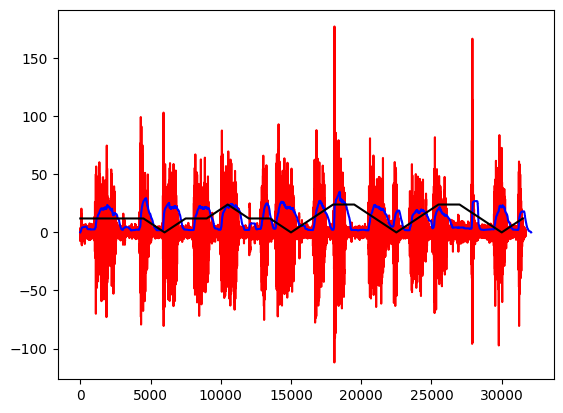

In [635]:
data = window_rms(data_origin[3300:35000], 400)
plt.plot(range(len(data_origin[3300:35000])),data_origin[3300:35000], 'red')
plt.plot(range(len(data)), data,'blue')
plt.plot(np.array(range(len(CALIBRATION_CODE[:22])))* 1500, np.array(CALIBRATION_CODE_NUM[:22]) * 12, 'black')

In [636]:
EPOCH_TIME = len(data) // len(CALIBRATION_CODE)
TIMING_ERROR = EPOCH_TIME//3
EPOCH_TIME,TIMING_ERROR

(1459, 486)

In [637]:
epochs = [data[max(i - TIMING_ERROR,0): min(len(data), i + EPOCH_TIME + TIMING_ERROR)]# min and max to avoid boundary effect
          for i in range(0,len(data), EPOCH_TIME)]# extend epochs at both ends to accept blinks at wrong timing
epochs_mean = list(map(np.mean, epochs))

## Optimizing thresholds

### Exploration

In [638]:
classified_epochs = np.array(list(zip(epochs_mean, CALIBRATION_CODE_NUM)))
classified_epochs

array([[ 9.7909639 ,  1.        ],
       [13.42395396,  1.        ],
       [ 9.71494796,  1.        ],
       [12.33489669,  1.        ],
       [11.89210038,  0.        ],
       [12.84462624,  1.        ],
       [15.54473597,  1.        ],
       [13.47899285,  2.        ],
       [10.19464315,  1.        ],
       [16.34297576,  1.        ],
       [13.7056669 ,  0.        ],
       [10.65943562,  1.        ],
       [18.03403401,  2.        ],
       [10.28465291,  2.        ],
       [12.08592159,  1.        ],
       [10.79631983,  0.        ],
       [11.18211865,  1.        ],
       [12.8305045 ,  2.        ],
       [ 9.26064442,  2.        ],
       [ 7.72730534,  1.        ],
       [ 9.04813788,  0.        ],
       [ 8.76897633,  1.        ],
       [ 5.07445733,  1.        ]])

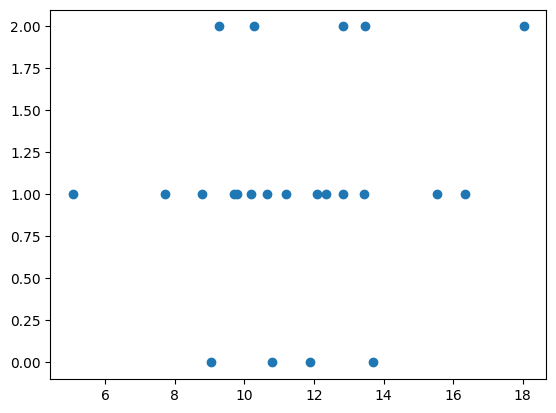

In [639]:
plt.scatter(*[[i[j] for i in classified_epochs] for j in range(2)])

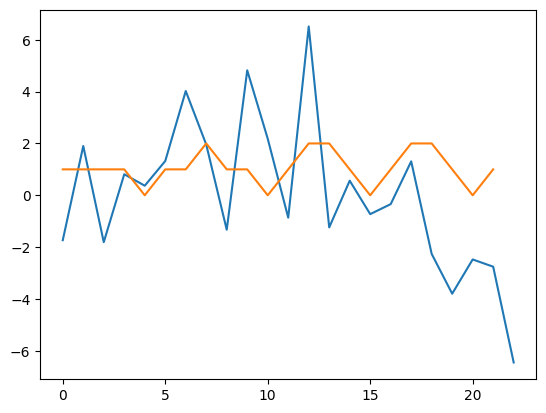

In [640]:
x = range(len(epochs_mean))
plt.plot(x, np.array(epochs_mean) - np.mean(epochs_mean))
plt.plot(x[:-1], CALIBRATION_CODE_NUM[:22])

### Optimizing

## Classifying by epochs

In [641]:
def classify_epoch(epoch: float, high_threshold, low_threshold):
  if epoch > high_threshold:
    res = '-'
  elif epoch > low_threshold:
    res = '*'
  else:
    res = ' '
  return res

In [741]:
file_name = '/Users/st2/Desktop/Repositories/morse-with-callibri/core/test_data/мама мыла раму/260424200650165.edf'
with pyedflib.EdfReader(file_name) as f:
    data = f.readSignal(0)
    SAMPLING_FREQUENCY = f.getSampleFrequency(0)
CALIBRATION_CODE = '.... ..-.. .--. .--. ..  .... .- ..- ...'.replace('.', '*')
CALIBRATION_TRANSLATION = translate_from_morse(CALIBRATION_CODE)
morse_symbol_to_class = {' ': 0, '*': 1, '-': 2}
CALIBRATION_CODE_NUM = [morse_symbol_to_class[i] for i in CALIBRATION_CODE]
CALIBRATION_TRANSLATION

'Хэппи хаус '

In [742]:
#TODO: get noise value of user's callibri and remove it from beginning and end of calibration data. here it is hardcoded
data = data[2850:]

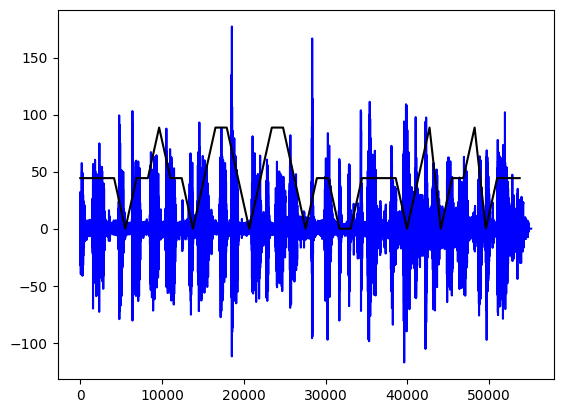

In [743]:
plt.plot(range(len(data)), data, 'blue')
plt.plot(list(range(0, len(data), len(data)//len(CALIBRATION_CODE_NUM)))[:-1], [i * np.max(data) / 4 for i in CALIBRATION_CODE_NUM], 'black')
plt.show()